In [1]:
# Install scikit-learn for the LFW dataset helper
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, applications
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import random

2025-07-21 18:09:57.093565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-21 18:09:57.093666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-21 18:09:57.187558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 18:09:57.379992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-21 18:09:58.794000: W tensorflow/compiler/tf2

In [2]:
# Load the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Get image data and labels
X = lfw_people.data
y = lfw_people.target
n_features = X.shape[1]
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Reshape images to be suitable for a CNN
X_images = X.reshape(-1, 50, 37, 1)

# Normalize pixel values to be between 0 and 1
X_images = X_images.astype('float32') / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size=0.25, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Number of identities: {n_classes}")

Training samples: 966
Testing samples: 322
Number of identities: 7


In [3]:
def create_embedding_model(input_shape=(50, 37, 1)):
    """Creates the base CNN model that learns to generate embeddings."""
    model_input = Input(shape=input_shape)
    
    # Using a simple CNN architecture
    x = Conv2D(32, (3, 3), activation='relu')(model_input)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    # The final embedding layer
    embedding = Dense(64)(x) # 64-dimensional embedding
    
    model = Model(model_input, embedding, name="embedding_model")
    return model

# Instantiate the base model
input_shape = X_train.shape[1:]
embedding_model = create_embedding_model(input_shape)
embedding_model.summary()

Model: "embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 37, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 35, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 17, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 15, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4928)          

2025-07-21 18:10:13.924573: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-21 18:10:14.401341: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# 1. Create data pairs
def create_bce_pairs(images, labels):
    pairs = []
    pair_labels = []
    num_classes = len(np.unique(labels))
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    
    for idx1 in range(len(images)):
        # Add a genuine pair
        img1 = images[idx1]
        label1 = labels[idx1]
        idx2 = random.choice(digit_indices[label1])
        img2 = images[idx2]
        pairs.append([img1, img2])
        pair_labels.append(1) # Label 1 for genuine
        
        # Add an imposter pair
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)
        idx2 = random.choice(digit_indices[label2])
        img2 = images[idx2]
        pairs.append([img1, img2])
        pair_labels.append(0) # Label 0 for imposter
        
    return np.array(pairs), np.array(pair_labels)

# Create training and testing pairs
train_pairs_bce, train_labels_bce = create_bce_pairs(X_train, y_train)
test_pairs_bce, test_labels_bce = create_bce_pairs(X_test, y_test)

# 2. Build the Siamese model for BCE
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Re-use the same embedding model instance for both inputs
embedding_a = embedding_model(input_a)
embedding_b = embedding_model(input_b)

# Calculate the L1 distance between embeddings
distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([embedding_a, embedding_b])

# Classifier layer
outputs = Dense(1, activation='sigmoid')(distance)
bce_model = Model([input_a, input_b], outputs)

# 3. Compile and train
bce_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

history_bce = bce_model.fit(
    [train_pairs_bce[:, 0], train_pairs_bce[:, 1]],
    train_labels_bce,
    validation_data=([test_pairs_bce[:, 0], test_pairs_bce[:, 1]], test_labels_bce),
    batch_size=64,
    epochs=10
)

Epoch 1/10
31/31 [==============================] - 3s 63ms/step - loss: 0.6931 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 2/10
31/31 [==============================] - 2s 58ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
31/31 [==============================] - 2s 62ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
31/31 [==============================] - 2s 55ms/step - loss: 0.6931 - accuracy: 0.5212 - val_loss: 0.6931 - val_accuracy: 0.5031
Epoch 5/10
31/31 [==============================] - 2s 59ms/step - loss: 0.6931 - accuracy: 0.5595 - val_loss: 0.6931 - val_accuracy: 0.5248
Epoch 6/10
31/31 [==============================] - 2s 65ms/step - loss: 0.6931 - accuracy: 0.5305 - val_loss: 0.6931 - val_accuracy: 0.4953
Epoch 7/10
31/31 [==============================] - 2s 60ms/step - loss: 0.6931 - accuracy: 0.5471 - val_loss: 0.6931 - val_accuracy: 0.5124
Epoch 8/10
31

In [5]:
# 1. Create data pairs (same as BCE but with different labels for loss)
# We can reuse the pairs from BCE, just need to adjust labels for the loss function
# For contrastive loss: 0 for genuine, 1 for imposter
train_labels_contrastive = 1 - train_labels_bce
test_labels_contrastive = 1 - test_labels_bce

# 2. Define the Contrastive Loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, tf.float32)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * margin_square + (1 - y_true) * square_pred)

# 3. Build the Siamese model for Contrastive Loss
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Create a fresh embedding model for this method
embedding_model_contrastive = create_embedding_model(input_shape)
embedding_a = embedding_model_contrastive(input_a)
embedding_b = embedding_model_contrastive(input_b)

# Calculate Euclidean distance
distance = Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True)))([embedding_a, embedding_b])

contrastive_model = Model([input_a, input_b], distance)

# 4. Compile and train
contrastive_model.compile(loss=contrastive_loss, optimizer=Adam(0.0001))

history_contrastive = contrastive_model.fit(
    [train_pairs_bce[:, 0], train_pairs_bce[:, 1]],
    train_labels_contrastive,
    validation_data=([test_pairs_bce[:, 0], test_pairs_bce[:, 1]], test_labels_contrastive),
    batch_size=64,
    epochs=10
)

Epoch 1/10
31/31 [==============================] - 3s 61ms/step - loss: 0.4973 - val_loss: 0.4927
Epoch 2/10
31/31 [==============================] - 2s 59ms/step - loss: 0.4817 - val_loss: 0.4615
Epoch 3/10
31/31 [==============================] - 2s 57ms/step - loss: 0.4303 - val_loss: 0.3830
Epoch 4/10
31/31 [==============================] - 2s 57ms/step - loss: 0.3555 - val_loss: 0.3254
Epoch 5/10
31/31 [==============================] - 2s 60ms/step - loss: 0.3326 - val_loss: 0.3198
Epoch 6/10
31/31 [==============================] - 2s 62ms/step - loss: 0.3268 - val_loss: 0.3167
Epoch 7/10
31/31 [==============================] - 2s 56ms/step - loss: 0.3218 - val_loss: 0.3133
Epoch 8/10
31/31 [==============================] - 2s 63ms/step - loss: 0.3155 - val_loss: 0.3088
Epoch 9/10
31/31 [==============================] - 2s 62ms/step - loss: 0.3121 - val_loss: 0.3056
Epoch 10/10
31/31 [==============================] - 2s 63ms/step - loss: 0.3082 - val_loss: 0.3048


In [6]:
# 1. Create data triplets
def create_triplets(images, labels):
    triplets = []
    num_classes = len(np.unique(labels))
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for i in range(len(images)):
        # Anchor
        anchor_img = images[i]
        anchor_label = labels[i]
        
        # Positive
        positive_idx = random.choice(digit_indices[anchor_label])
        positive_img = images[positive_idx]
        
        # Negative
        negative_label = random.randint(0, num_classes - 1)
        while negative_label == anchor_label:
            negative_label = random.randint(0, num_classes - 1)
        negative_idx = random.choice(digit_indices[negative_label])
        negative_img = images[negative_idx]
        
        triplets.append([anchor_img, positive_img, negative_img])
        
    return np.array(triplets)

# Create training and testing triplets
train_triplets = create_triplets(X_train, y_train)
test_triplets = create_triplets(X_test, y_test)

# 2. Define the Triplet Loss function
class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        anchor, positive, negative = inputs
        p_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        n_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        loss = tf.maximum(p_dist - n_dist + self.alpha, 0.0)
        return tf.reduce_mean(loss)

# 3. Build the Triplet model
input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

# Create a fresh embedding model for this method
embedding_model_triplet = create_embedding_model(input_shape)
embedding_anchor = embedding_model_triplet(input_anchor)
embedding_positive = embedding_model_triplet(input_positive)
embedding_negative = embedding_model_triplet(input_negative)

# Loss layer
loss_layer = TripletLossLayer(alpha=0.2)([embedding_anchor, embedding_positive, embedding_negative])

triplet_model = Model(
    inputs=[input_anchor, input_positive, input_negative],
    outputs=loss_layer
)

# 4. Compile and train
# The model's output is the loss, so we use a dummy lambda function for the loss argument
triplet_model.compile(optimizer=Adam(0.0001), loss=lambda y_true, y_pred: y_pred)

# We don't need y_train, so we can use a placeholder
dummy_y = np.zeros(len(train_triplets))

history_triplet = triplet_model.fit(
    [train_triplets[:, 0], train_triplets[:, 1], train_triplets[:, 2]],
    dummy_y,
    validation_data=([test_triplets[:, 0], test_triplets[:, 1], test_triplets[:, 2]], np.zeros(len(test_triplets))),
    batch_size=64,
    epochs=10
)

Epoch 1/10
16/16 [==============================] - 2s 95ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 2/10
16/16 [==============================] - 1s 78ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 3/10
16/16 [==============================] - 1s 80ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 4/10
16/16 [==============================] - 1s 79ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 5/10
16/16 [==============================] - 1s 78ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 6/10
16/16 [==============================] - 1s 79ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 7/10
16/16 [==============================] - 1s 78ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 8/10
16/16 [==============================] - 1s 78ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 9/10
16/16 [==============================] - 1s 82ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 10/10
16/16 [==============================] - 1s 79ms/step - loss: 0.2000 - val_loss: 0.2000


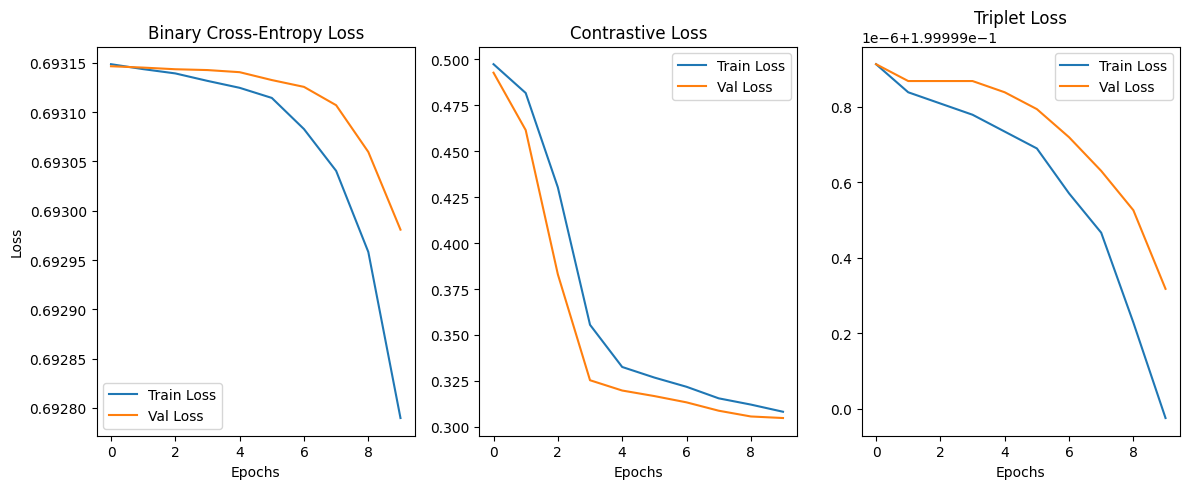

In [7]:
plt.figure(figsize=(12, 5))

# Plot BCE Loss
plt.subplot(1, 3, 1)
plt.plot(history_bce.history['loss'], label='Train Loss')
plt.plot(history_bce.history['val_loss'], label='Val Loss')
plt.title('Binary Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Contrastive Loss
plt.subplot(1, 3, 2)
plt.plot(history_contrastive.history['loss'], label='Train Loss')
plt.plot(history_contrastive.history['val_loss'], label='Val Loss')
plt.title('Contrastive Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot Triplet Loss
plt.subplot(1, 3, 3)
plt.plot(history_triplet.history['loss'], label='Train Loss')
plt.plot(history_triplet.history['val_loss'], label='Val Loss')
plt.title('Triplet Loss')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Visualizing BCE Embeddings...
11/11 [==============================] - 0s 6ms/step


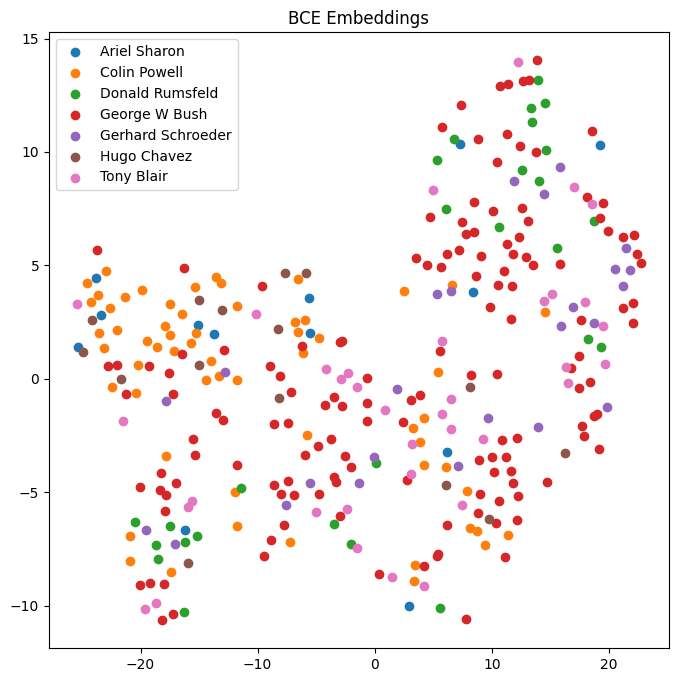

Visualizing Contrastive Embeddings...
11/11 [==============================] - 0s 4ms/step


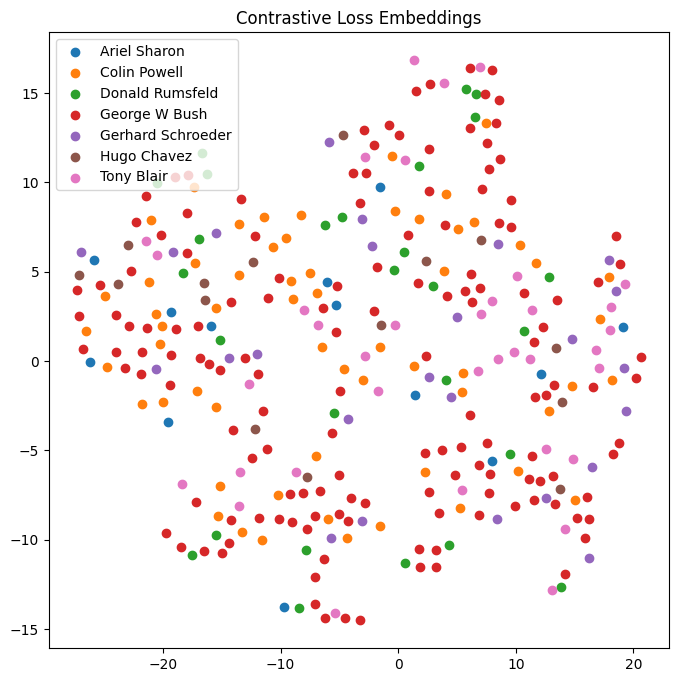

Visualizing Triplet Embeddings...
11/11 [==============================] - 0s 4ms/step


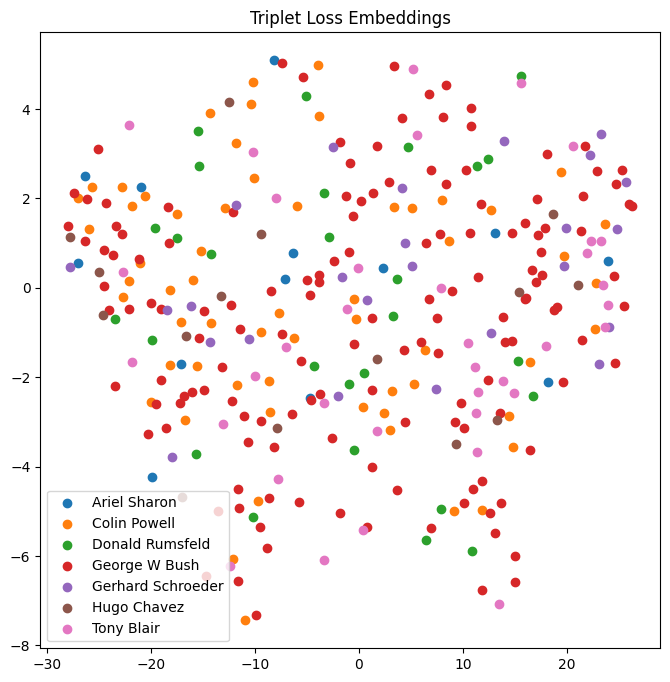

In [8]:
def plot_tsne(embedding_model, X_data, y_data, title):
    # Get embeddings
    embeddings = embedding_model.predict(X_data)
    
    # Use t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        indices = np.where(y_data == i)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=target_names[i])
    
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize embeddings from each model
print("Visualizing BCE Embeddings...")
plot_tsne(embedding_model, X_test, y_test, "BCE Embeddings")

print("Visualizing Contrastive Embeddings...")
plot_tsne(embedding_model_contrastive, X_test, y_test, "Contrastive Loss Embeddings")

print("Visualizing Triplet Embeddings...")
plot_tsne(embedding_model_triplet, X_test, y_test, "Triplet Loss Embeddings")